## Libraries preparation

In [1]:
# Load python packages
import cv2
import numpy as np
import scipy 
import scipy.linalg 
from scipy.misc import imread
#import pykitti
import glob
import yaml
import csv

# Inline plotting or interactive? 
# Attention:
# 1. Need restart kernel
# 2. Need to declare before import matplotlib
%matplotlib inline
#%matplotlib notebook

import matplotlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


#-------------
# Dataset location
#-------------
# Change this to the directory where you store EuRoC MAV data
basedir = '/work/asl_dataset/ijrr_euroc_mav_dataset/machine_hall/MH_01_easy/'
#basedir = '/Users/jcli/study/asl_dataset/ijrr_euroc_mav_dataset/machine_hall/MH_01_easy/'

## Tile-based KLT tracker

image size (w, h):  752 480
Tile (y,x): 0 0
New corners detected: 35
Total corners (35, 1, 2)
Tile (y,x): 0 100
New corners detected: 50
Total corners (85, 1, 2)
Tile (y,x): 0 200
New corners detected: 50
Total corners (135, 1, 2)
Tile (y,x): 0 300
New corners detected: 50
Total corners (185, 1, 2)
Tile (y,x): 0 400
New corners detected: 50
Total corners (235, 1, 2)
Tile (y,x): 0 500
New corners detected: 50
Total corners (285, 1, 2)
Tile (y,x): 0 600
New corners detected: 45
Total corners (330, 1, 2)
Tile (y,x): 0 700
New corners detected: 9
Total corners (339, 1, 2)
Tile (y,x): 100 0
New corners detected: 46
Total corners (385, 1, 2)
Tile (y,x): 100 100
New corners detected: 50
Total corners (435, 1, 2)
Tile (y,x): 100 200
New corners detected: 50
Total corners (485, 1, 2)
Tile (y,x): 100 300
New corners detected: 50
Total corners (535, 1, 2)
Tile (y,x): 100 400
New corners detected: 50
Total corners (585, 1, 2)
Tile (y,x): 100 500
New corners detected: 50
Total corners (635, 1, 2)
T

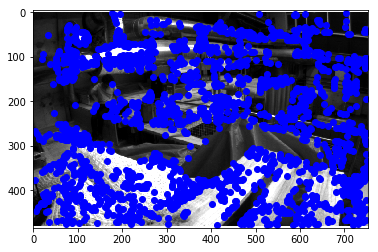

Frame  1 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1910, 4)


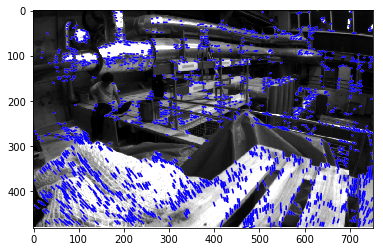

Frame  2 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1906, 4)


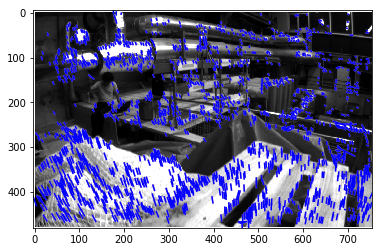

In [17]:
# Local scripts
import tile_of_func as of


#-------------
# Global Parameters
#-------------
## Interactive mode - show image of every frame interactively.
INTERACTIVE = True


# Tile size
tile_size = 100

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 3, 1)

#-------------
# Main(): Processing cam
#-------------

for fr in frame_range:
    #Pyplot figure size
    plt.figure(figsize=(12,4))
    plt.autoscale(tight=True)

    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    plt.imshow(cam0,cmap='gray')

    # Optical flow tracking
    # Feature list for consistency check
    feature_list = []

    # First frame, mark feature
    if fr==0:

        (cam0_height, cam0_width) = cam0.shape
        print("image size (w, h): ", cam0_width, cam0_height)

        # Split image into tile_size to find features
        p0 = of.OF_TileFindFeature(cam0, tile_size, of.feature_params)
        #DEBUG print(p0.shape, p0)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='b')

    # Optical flow tracking
    else:


        print("Frame ", fr, ":")
        # Forward OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **of.lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        # Backward OF tracking
        p2, st2, err = cv2.calcOpticalFlowPyrLK(cam0, old_cam0, p1, None, **of.lk_params)

        # Clean-up feature_list
        feature_list = of.OF_FeatureListFilter(p0, p1, p2, cam0_width, cam0_height)

        # Draw filtered feature points and associated OF
        for idx in range(feature_list.shape[0]):
            plt.plot([feature_list[idx,0], feature_list[idx,2]], 
                            [feature_list[idx,1], feature_list[idx,3]],
                            linestyle='-', color='plum')

        # Draw old feature points
        #plt.scatter(good_old[:,0], good_old[:,1], marker='^', c='g')
        # Draw new feature points
        #plt.scatter(good_new[:,0], good_new[:,1], marker='o', c='r')
        # Draw optical flow
        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color='b')

        # Find affine parameters sx,sy,tx,ty for each grid
        #of.OF_TileAffineSolver(cam0, tile_size, feature_list)

        # Save points for next round
        p0 = good_new.reshape(-1,1,2)



    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'_of.png')
    # Show the OF tracking image
    if INTERACTIVE:
        plt.show()
    
        ## Use opencv to show image
        #cv2.imshow('cam0',cam0)
        #k = cv2.waitKey(-1)
        #cv2.destroyAllWindows()

## Frame-level KLT tracker

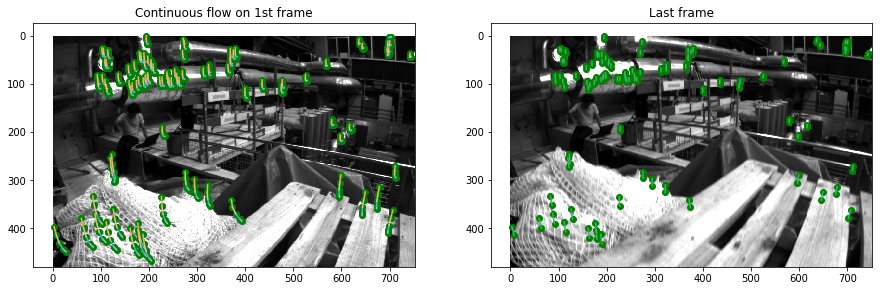

In [5]:
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#-------------
# Optical Flow related setting
#-------------
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 5, 1)

#-------------
# Processing cam
#-------------
dpi = 50

# Read 1st frame
cam0 = cv2.imread(cam0_img_list[0], cv2.IMREAD_GRAYSCALE)

# Create a figure of the right size with one axes that takes up the full figure
height, width = cam0.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)

# Show the gray img from camera 0
plt.subplot(121)
plt.imshow(cam0, cmap='gray', extent=[0,width,height,0])
plt.title("Continuous flow on 1st frame")

for fr in frame_range:
    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    
    # Optical flow tracking
    # First frame, mark feature
    if fr==0:
        p0 = cv2.goodFeaturesToTrack(cam0, mask = None, **feature_params)
        #plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='r')
        
    # Draw flow
    else:
        # OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
        plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
        cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color=cur_rand_color)

        p0 = good_new.reshape(-1,1,2)

    old_cam0 = cam0.copy()

    # Save pyplot image
    #plt.savefig(str(fr).zfill(3)+'.png')
    
# Show the image with continuous flow
#plt.show()

# Draw last frame

plt.subplot(122)
plt.imshow(cam0, cmap='gray', extent=[0,width,height,0])
plt.title("Last frame")
plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

for idx in range(good_old.shape[0]):
    plt.plot([good_old[idx,0], good_new[idx,0]], 
                    [good_old[idx,1], good_new[idx,1]],
                    linestyle='-', color=cur_rand_color)
plt.show()

    # Use opencv to show image
    #cv2.imshow('cam0',cam0)
    #k = cv2.waitKey(-1)
    #cv2.destroyAllWindows()
    

## Camera distortion correction

Use page: https://hackaday.io/project/12384-autofan-automated-control-of-air-flow/log/41862-correcting-for-lens-distortions

cam0 intrinsics = 
 [[ 458.654    0.     367.215]
 [   0.     457.296  248.375]
 [   0.       0.       1.   ]]
cam0 distortion_coeffs = 
 [ -2.83408110e-01   7.39590700e-02   1.93590000e-04   1.76187114e-05
   0.00000000e+00]
cam0 T_BS (MAV body to camera sensor) = 
 [[ 0.01486554 -0.99988093  0.0041403  -0.02164015]
 [ 0.99955725  0.01496721  0.02571553 -0.06467699]
 [-0.02577444  0.00375619  0.99966073  0.00981073]
 [ 0.          0.          0.          1.        ]]


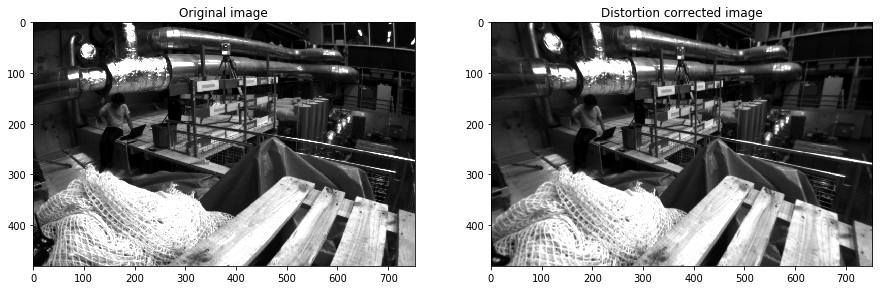

(480, 752) (480, 752) (480, 752)


In [2]:
import yaml

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

#-------------
# Processing cam
#-------------
dpi = 50

# Read 1st frame
cam0 = cv2.imread(cam0_img_list[0], cv2.IMREAD_GRAYSCALE)


# Load cam0 sensor config
with open(basedir+'mav0/cam0/sensor.yaml') as fp:
    cam0_yaml = yaml.load(fp)
#print(cam0_yaml)
fp.close()

# K - intrinsics
K_params = cam0_yaml['intrinsics']
K = np.array([
    [K_params[0], 0., K_params[2]],
    [0., K_params[1], K_params[3]],
    [0., 0., 1.]
]) 
print("cam0 intrinsics = \n", K)

# D - distortion coefficients
D_params = cam0_yaml['distortion_coefficients']
D = np.hstack([D_params[:], 0.])
print("cam0 distortion_coeffs = \n", D)

w, h = cam0_yaml['resolution']

# T_BS - [R t] from MAV body coordinates to sensor (cam0) coordinates
T_BS = cam0_yaml['T_BS']['data']
T_BS_cols = cam0_yaml['T_BS']['cols']
T_BS_rows = cam0_yaml['T_BS']['rows']
T_BS = np.array(T_BS).reshape(T_BS_rows, T_BS_cols)
print("cam0 T_BS (MAV body to camera sensor) = \n", T_BS)

# Generate new camera matrix from parameters
newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(K, D, (w,h), 0)

# Generate look-up tables for remapping the camera image
mapx, mapy = cv2.initUndistortRectifyMap(K, D, None, newcameramatrix, (w, h), 5)

# Remap the original image to a new image
#new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR)
new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)

# Display old and new image
dpi = 50
# Create a figure of the right size with one axes that takes up the full figure
height, width = cam0.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)

# Show the gray img from camera 0
plt.subplot(121)
plt.imshow(cam0, cmap='gray', extent=[0,width,height,0])
plt.title('Original image')
plt.subplot(122)
plt.imshow(new_cam0, cmap='gray', extent=[0,width,height,0])
plt.title('Distortion corrected image')
plt.show()

print(mapx.shape, mapy.shape,cam0.shape)

## Frame-level KLT tracker on undistorted image

num of total feature points: 100
num of active feature points: 100
num of total feature points: 100
num of active feature points: 100
num of total feature points: 100
num of active feature points: 99
num of total feature points: 100
num of active feature points: 98
num of total feature points: 100
num of active feature points: 98
num of total feature points: 100
num of active feature points: 96
num of total feature points: 100
num of active feature points: 96
num of total feature points: 100
num of active feature points: 96
num of total feature points: 100
num of active feature points: 96


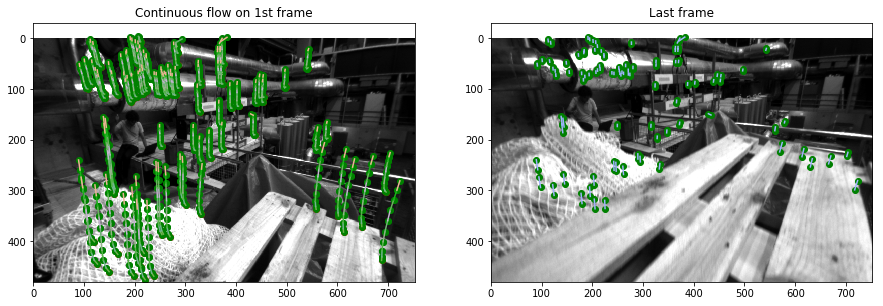

In [7]:
#-------------
# Optical Flow related setting
#-------------
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

# No of frames to process
frame_range = range(0, 10, 1)

#-------------
# Processing cam
#-------------
dpi = 50

# Read 1st frame
cam0_ori = cv2.imread(cam0_img_list[frame_range[0]], cv2.IMREAD_GRAYSCALE)
# Image undistortion
cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)


# Create a figure of the right size with one axes that takes up the full figure
height, width = cam0.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)

# Show the gray img from camera 0
plt.subplot(121)
plt.imshow(cam0, cmap='gray', extent=[0,width,height,0])
plt.title("Continuous flow on 1st frame")

for fr in frame_range:
    cam0_ori = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    # Image undistortion
    cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)
    
    # Optical flow tracking
    # First frame, mark feature
    if fr==frame_range[0]:
        p0 = cv2.goodFeaturesToTrack(cam0, mask = None, **feature_params)
        # Save the very first set of features
        good_ori = p0.copy()
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='r')
        
    # Draw flow
    else:
        # OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
        plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
        cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color=cur_rand_color)

        #<<hack>> p0 = good_new.reshape(-1,1,2)
        p0 = p1.reshape(-1,1,2)
        print("num of total feature points:", p0.shape[0])
        print("num of active feature points:", good_new.shape[0])

    old_cam0 = cam0.copy()

    # Save pyplot image
    #plt.savefig(str(fr).zfill(3)+'.png')
    
# Show the image with continuous flow
#plt.show()

# Draw last frame
plt.subplot(122)
plt.imshow(cam0, cmap='gray', extent=[0,width,height,0])
plt.title("Last frame")

plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

for idx in range(good_old.shape[0]):
    plt.plot([good_old[idx,0], good_new[idx,0]], 
                    [good_old[idx,1], good_new[idx,1]],
                    linestyle='-', color=cur_rand_color)
plt.show()


    # Use opencv to show image
    #cv2.imshow('cam0',cam0)
    #k = cv2.waitKey(-1)
    #cv2.destroyAllWindows()

## Pose estimation using 8-pt algorithm

### Utility functions

In [25]:
'''
PLOT_EPIPOLAR_LINES_ON_IMAGES given a pair of images and corresponding points,
draws the epipolar lines on the images
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    im1 - a HxW(xC) matrix that contains pixel values from the first image 
    im2 - a HxW(xC) matrix that contains pixel values from the second image 
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    Nothing; instead, plots the two images with the matching points and
    their corresponding epipolar lines. See Figure 1 within the problem set
    handout for an example
'''
def plot_epipolar_lines_on_images(points1, points2, im1, im2, F):
    # Epipolar line in second image: l' = F x
    epi_l_p = np.matmul(F, points1.T).T
    # Draw points onto image2
    fig = plt.figure(figsize=(16, 12)) 
    plt.subplot(121)
    plt.plot(points2[:,0], points2[:,1], 'ro')
    
    # Draw epipolar lines on image2
    num_lines = epi_l_p.shape[0]
    for i in range(num_lines):
        a,b,c = epi_l_p[i]
        x = np.array([0., im2.shape[1]])
        y = -(a*x + c)/b
        plt.plot(x,y,color='b',linewidth=0.5)
        # Plot calculated corresponding points
        plt.plot(points2[i,0], -(a*points2[i,0]+c)/b, 'go')
        
    #plt.imshow(im2, extent=[0, 512, 512, 0], cmap='gray')
    #plt.imshow(im2, cmap='gray', aspect='auto')
    plt.imshow(im2, cmap='gray', extent=[0,im2.shape[1],im2.shape[0],0])
    
    # Epipolar line in first image: l = F^T x'
    epi_l = np.matmul(F.T, points2.T).T
    # Draw points onto image1
    plt.subplot(122)
    plt.plot(points1[:,0], points1[:,1], 'ro')
    
    # Draw epipolar lines on image1
    num_lines = epi_l.shape[0]
    for i in range(num_lines):
        a,b,c = epi_l[i]
        x = np.array([0., im1.shape[1]])
        y = -(a*x + c)/b
        plt.plot(x,y,color='b',linewidth=0.5)
        # Plot calculated corresponding points
        plt.plot(points1[i,0], -(a*points1[i,0]+c)/b, 'go')
        
    #plt.imshow(im1, extent=[0, 512, 512, 0], cmap='gray')
    #plt.imshow(im1, cmap='gray', aspect='auto')
    plt.imshow(im1, cmap='gray', extent=[0,im1.shape[1],im1.shape[0],0])
    plt.show()
    

def plot_points_on_images(points1, points2, im1, im2, F):
    # Epipolar line in second image: l' = F x
    epi_l_p = np.matmul(F, points1.T).T
    # Draw points onto image2
    fig = plt.figure(figsize=(16, 12)) 
    plt.subplot(121)
    plt.plot(points2[:,0], points2[:,1], 'ro', markersize=5)
    
    # Draw epipolar lines on image2
    num_lines = epi_l_p.shape[0]
    for i in range(num_lines):
        a,b,c = epi_l_p[i]
        # Plot calculated corresponding points
        plt.plot(points2[i,0], -(a*points2[i,0]+c)/b, 'go', markersize=5)
        
    #plt.imshow(im2, extent=[0, 512, 512, 0], cmap='gray')
    #plt.imshow(im2, cmap='gray', aspect='auto')
    plt.imshow(im2, cmap='gray', extent=[0,im2.shape[1],im2.shape[0],0])
    
    # Epipolar line in first image: l = F^T x'
    epi_l = np.matmul(F.T, points2.T).T
    # Draw points onto image1
    plt.subplot(122)
    plt.plot(points1[:,0], points1[:,1], 'ro', markersize=5)
    
    # Draw epipolar lines on image1
    num_lines = epi_l.shape[0]
    for i in range(num_lines):
        a,b,c = epi_l[i]
        # Plot calculated corresponding points
        plt.plot(points1[i,0], -(a*points1[i,0]+c)/b, 'go', markersize=5)
        
    #plt.imshow(im1, extent=[0, 512, 512, 0], cmap='gray')
    #plt.imshow(im1, cmap='gray', aspect='auto')
    plt.imshow(im1, cmap='gray', extent=[0,im1.shape[1],im1.shape[0],0])
    plt.show()
    
'''
LLS_EIGHT_POINT_ALG  computes the fundamental matrix from matching points using 
linear least squares eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the linear least squares eight
point algorithm works
'''
def lls_eight_point_alg(points1, points2):
    x1 = points1[:,0].reshape(-1,1)
    y1 = points1[:,1].reshape(-1,1)
    x1p = points2[:,0].reshape(-1,1)
    y1p = points2[:,1].reshape(-1,1)
    
    # Come up with Af=0
    A = np.hstack([x1p*x1, x1p*y1, x1p, y1p*x1, y1p*y1, y1p, x1, y1, \
                   points1[:,2].reshape(-1,1)])
    # Using SVD to find least-square solution of f 
    U,s,V_transpose = np.linalg.svd(A)
    # f is the last column of V
    f = V_transpose[-1,:]
    F = f.reshape(3,3)/f[-1]
    
    # Using SVD again to decompose F
    U1,s1,V1_transpose = np.linalg.svd(F)
    # Force rank 2
    D = np.zeros([3,3])
    D[0,0]=s1[0]
    D[1,1]=s1[1]
    # Get F'
    Fp = np.matmul(U1, np.matmul(D, V1_transpose))
    return Fp

'''
NORMALIZED_EIGHT_POINT_ALG  computes the fundamental matrix from matching points
using the normalized eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the normalized eight
point algorithm works
'''
def normalized_eight_point_alg(points1, points2):
    # Find mean of x,y co-ordinates
    ave_pts1 = np.mean(points1,axis=0)
    ave_pts2 = np.mean(points2,axis=0)
    # Calc mean distance to centroid points
    tmp1 = points1 - ave_pts1
    dist1 = np.mean(np.sqrt((tmp1[:,0])**2 + (tmp1[:,1])**2))
    scale1 = 2./dist1
    tmp2 = points2 - ave_pts2
    dist2 = np.mean(np.sqrt((tmp2[:,0])**2 + (tmp2[:,1])**2))
    scale2 = 2./dist2
    # T matrices
    T1 = np.array([[scale1, 0., 0.], [0., scale1, 0.],
            [-scale1*ave_pts1[0], -scale1*ave_pts1[1], 1.]])
    T2 = np.array([[scale2, 0., 0.], [0., scale2, 0.],
            [-scale2*ave_pts2[0], -scale2*ave_pts2[1], 1.]])
    # normalized points
    norm_pts1 = np.matmul(points1, T1)
    norm_pts2 = np.matmul(points2, T2)

    # Now run the linear least squares eight point algorithm
    F_lls = lls_eight_point_alg(norm_pts1, norm_pts2)
    
    # Un-normalize
    F = np.matmul(T2, np.matmul(F_lls, T1.T))
    F = F/F[2,2]

    return F


    
'''
COMPUTE_DISTANCE_TO_EPIPOLAR_LINES  computes the average distance of a set a 
points to their corresponding epipolar lines
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    average_distance - the average distance of each point to the epipolar line
'''
def compute_distance_to_epipolar_lines(points1, points2, F):
    # Epipolar line in image 1 from F and points2
    epi_l= np.matmul(F.T, points2.T).T
    # line ax+by+c=0
    a = epi_l[:,0]
    b = epi_l[:,1]
    c = epi_l[:,2]
    # Points to be calculated distance
    x0 = points1[:,0]
    y0 = points1[:,1]
    # Distance calculated
    d = np.abs(a*x0+b*y0+c)/np.sqrt(a**2+b**2)
    
    return np.mean(d)



'''
ESTIMATE_INITIAL_RT from the Essential Matrix, we can compute 4 initial
guesses of the relative RT between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
Returns:
    RT: A 4x3x4 tensor in which the 3x4 matrix RT[i,:,:] is one of the
        four possible transformations
'''
def estimate_initial_RT(E):
    U, s, V_trans = np.linalg.svd(E)
    # Helper matrices
    Z = np.array([[0,1,0], [-1,0,0], [0,0,0]])
    W = np.array([[0,-1,0], [1,0,0], [0,0,1]])
    # Calculate R
    R1 = U.dot(W.dot(V_trans))
    R2 = U.dot(W.T.dot(V_trans))
    R1_sign = np.linalg.det(R1)
    R2_sign = np.linalg.det(R2)
    R1 = -R1 if R1_sign<0 else R1
    R2 = -R2 if R2_sign<0 else R2
    # T
    T1 = U[:,2]
    T2 = -U[:,2]
    # RT
    RT = np.array([
            np.vstack([R1.T, T1]).T,
            np.vstack([R1.T, T2]).T,
            np.vstack([R2.T, T1]).T,
            np.vstack([R2.T, T2]).T
        ])

    return RT


'''
LINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point is the best linear estimate
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''
def linear_estimate_3d_point(image_points, camera_matrices):
    pts = image_points.copy()
    M = camera_matrices.copy()
    
    # Construct the 2m x 4 matrix A
    # x coord
    A1 = (M[:,2,:].T*pts[:,0]).T-M[:,0,:]
    # y coord
    A2 = (M[:,2,:].T*pts[:,1]).T-M[:,1,:]
    
    #Debug
    #print M[:,2,:].shape, pts[:,0].shape
    
    A = np.vstack([A1, A2])
    U, s, V_trans = np.linalg.svd(A)
    point_3d = V_trans[3,:].copy()
    #print "linear point_3d = ", point_3d
    point_3d /= point_3d[-1]
    #print "linear point_3d (normed) = ", point_3d
    return point_3d[:-1]


'''
REPROJECTION_ERROR given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image (NxMx3?)
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    error - the 2Mx1 reprojection error vector
'''
def reprojection_error(point_3d, image_points, camera_matrices):
    M = image_points.shape[0]
    # Reprojecting points to image
    proj_img_pts = np.matmul(camera_matrices, np.hstack([point_3d,1.]))
    # Normalize p' = [y1, y2]^T/y3
    proj_img_pts = proj_img_pts.T
    proj_img_pts /= proj_img_pts[-1,:]
    # Re-projection error
    reproj_error = proj_img_pts[:-1,:].T - image_points
    # Make it 2Mx1 vector
    reproj_error = reproj_error.reshape(2*M,)
    return reproj_error


'''
JACOBIAN given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    jacobian - the 2Mx3 Jacobian matrix
'''
def jacobian(point_3d, camera_matrices):
    # Write down element one by one, in vector form

    # homogeneous coordi of 3D point(s) X
    point_3d = np.hstack([point_3d, 1.])

    # derivative of -e + (cx+d)/(ax+b) is (bc-ad)/(ax+b)^2
    # Common denominator
    denom = (np.matmul(camera_matrices[:,2,:], point_3d))**2
    
    # Elements of row dx
    d_e_p11 = camera_matrices[:,0,0]*        np.matmul(camera_matrices[:,2,[1,2,3]], point_3d[[1,2,3]])         - camera_matrices[:,2,0]*        np.matmul(camera_matrices[:,0,[1,2,3]], point_3d[[1,2,3]]) 
    d_e_p12 = camera_matrices[:,0,1]*        np.matmul(camera_matrices[:,2,[0,2,3]], point_3d[[0,2,3]])         - camera_matrices[:,2,1]*        np.matmul(camera_matrices[:,0,[0,2,3]], point_3d[[0,2,3]])
    d_e_p13 = camera_matrices[:,0,2]*        np.matmul(camera_matrices[:,2,[0,1,3]], point_3d[[0,1,3]])         - camera_matrices[:,2,2]*        np.matmul(camera_matrices[:,0,[0,1,3]], point_3d[[0,1,3]])

    # Elements of row dy
    d_e_p21 = camera_matrices[:,1,0]*        np.matmul(camera_matrices[:,2,[1,2,3]], point_3d[[1,2,3]])         - camera_matrices[:,2,0]*        np.matmul(camera_matrices[:,1,[1,2,3]], point_3d[[1,2,3]])
    d_e_p22 = camera_matrices[:,1,1]*        np.matmul(camera_matrices[:,2,[0,2,3]], point_3d[[0,2,3]])         - camera_matrices[:,2,1]*        np.matmul(camera_matrices[:,1,[0,2,3]], point_3d[[0,2,3]])
    d_e_p23 = camera_matrices[:,1,2]*        np.matmul(camera_matrices[:,2,[0,1,3]], point_3d[[0,1,3]])         - camera_matrices[:,2,2]*        np.matmul(camera_matrices[:,1,[0,1,3]], point_3d[[0,1,3]])

    # Divide the denominator
    J1 = np.vstack([[d_e_p11], [d_e_p12], [d_e_p13]])
    J2 = np.vstack([[d_e_p21], [d_e_p22], [d_e_p23]])
    J1 = np.divide(J1, denom).T
    J2 = np.divide(J2, denom).T
    
    # Interleaving the result to be jacobian matrix
    J = np.zeros((2*J1.shape[0], J1.shape[1]))
    J[0::2,:] = J1
    J[1::2,:] = J2
    
    return J


'''
NONLINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point that iteratively updates the points
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''
def nonlinear_estimate_3d_point(image_points, camera_matrices):
    pts_im = image_points.copy()
    cam = camera_matrices.copy()
    
    # Number of iterations
    num_iter = 10
    
    pts_3d_nxt = linear_estimate_3d_point(pts_im, cam)
    
    for i in range(num_iter):    
        J = jacobian(pts_3d_nxt, cam)
        err = reprojection_error(pts_3d_nxt, pts_im, cam)
        delta_pts_3d = -np.matmul(np.matmul(np.linalg.inv(J.T.dot(J)),            J.T), err)
        # Debug
        #print " nonlinear 3d_point = ", pts_3d_nxt
        #print "error = ", err
        #print "delta_3d_point = ", delta_pts_3d, "\n"
        pts_3d_nxt += delta_pts_3d
    
    return pts_3d_nxt
 
'''
ESTIMATE_RT_FROM_E from the Essential Matrix, we can compute  the relative RT 
between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
    img_pts - N measured points in each of the M images (NxMx2 matrix)
    K - the intrinsic camera matrix
Returns:
    RT: The 3x4 matrix which gives the rotation and translation between the 
        two cameras
'''
def estimate_RT_from_E(E, img_pts, K):
    # Estimate the 4 candidate R,T pairs
    init_RT = estimate_initial_RT(E)

    #print("img_pts.shape=", img_pts.shape)

    # Voting counter
    cnt = [0,0,0,0]

    # Projective matrix M1
    M1 = K.dot(np.append(np.eye(3), np.zeros((3,1)), axis=1))

    # Go through each points
    for i in range(img_pts.shape[0]):
        for j in range(init_RT.shape[0]):
            # Projective matrix M2 candidate i
            M2 = K.dot(init_RT[j])

            M = np.array((M1,M2))

            # Calculate the 3D point
            # <<FIXME>> Using non-linear method will meet 'singular matrix' error, how to fix it?
            #X = nonlinear_estimate_3d_point(img_pts[i], M)
            X = linear_estimate_3d_point(img_pts[i], M)
            #print "3d point candidate ", j, " in cam1: ", X
            # Move X to camera2 coordinate system
            X2 = init_RT[j].dot(np.append(X, 1.).T) 
            #print "3d point candidate ", j, " in cam2: ", X2.T
            if X2[2] > 1.0 and X[2]> 1.0:
                #print("img_pts[i]=", img_pts[i], ",X=", X, ",X2=", X2)
                cnt[j] += 1

    index = np.argmax(cnt)
    #print("cnt = ", cnt, "index = ", index)
    RT = init_RT[index]
    return RT


def eval_RT(RT, img_pts, K):
    #print("img_pts.shape=", img_pts.shape)

    # Projective matrix M1
    M1 = K.dot(np.append(np.eye(3), np.zeros((3,1)), axis=1))

    # Projective matrix M2
    M2 = K.dot(RT)

    M = np.array((M1,M2))

    error = 0.

    for i in range(img_pts.shape[0]):
        # Calculate the 3D point i
        X = linear_estimate_3d_point(img_pts[i], M)
        #print("3d point in cam1: ", X)
    
        err = reprojection_error(X, img_pts[i], M)
        err = np.mean(abs(err))

        error += err

    error /= img_pts.shape[0]
    
    return error


def eval_RT_thresh(RT, img_pts, K):
    #print("img_pts.shape=", img_pts.shape)

    # Projective matrix M1
    M1 = K.dot(np.append(np.eye(3), np.zeros((3,1)), axis=1))

    # Projective matrix M2
    M2 = K.dot(RT)

    M = np.array((M1,M2))

    error = 0.
    inliers_cnt = 0
    SKIP_THRESH = 3 # distance of pixels threshold
    
    for i in range(img_pts.shape[0]):
        # Calculate the 3D point i
        X = linear_estimate_3d_point(img_pts[i], M)
        #print("3d point in cam1: ", X)
    
        err = reprojection_error(X, img_pts[i], M)
        err = np.mean(abs(err))
        
        if err<SKIP_THRESH:
            error += err
            inliers_cnt += 1
    
    if inliers_cnt>0:
        error /= inliers_cnt
    else:
        error = 1e+10
    
    return error, inliers_cnt




### Experiment

OF: processing frame  0
OF: processing frame  4
num of total feature points: 200
num of active feature points: 195


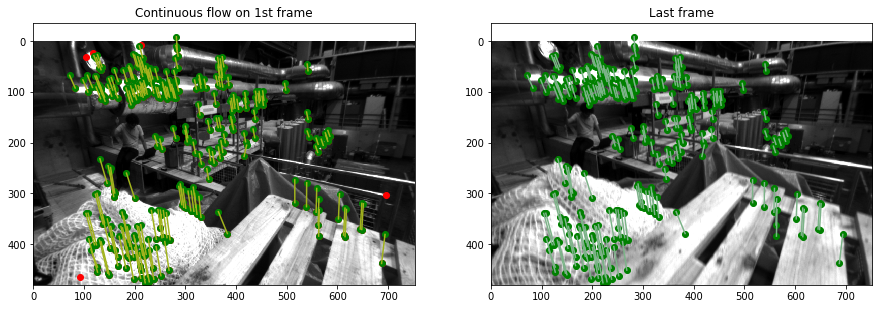


Initial pose estimation using all points:
Mean reproj error:  0.231749786205 inliers/total: 194 / 195 

p'^T F p = 1.43870123154
Estimated pose RT:
 [[ 0.99993672  0.00580425  0.00963667  0.01466123]
 [-0.00623773  0.99894124  0.04557942 -0.89506621]
 [-0.00936191 -0.04563664  0.99891424 -0.44569219]]


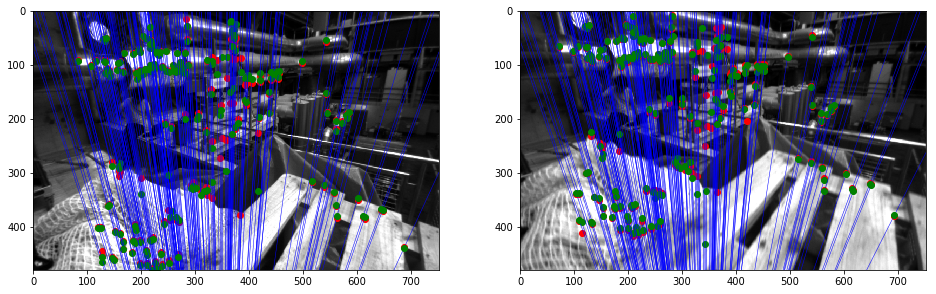

Mean reproj error:  0.193324512704 Inlier/total= 194 / 195
Mean reproj error:  0.173383449328 Inlier/total= 194 / 195

After 8pt algorithm RANSAC pose estimation:
p'^T F p = 1.72176593683
Fundamental Matrix from normalized 8-point algorithm:
 [[  1.90711921e-06   1.40557984e-04  -1.76539376e-01]
 [ -1.31044003e-04  -5.54169254e-07   4.74404689e-02]
 [  1.74532276e-01  -5.05620017e-02   1.00000000e+00]]
Estimated pose RT:
 [[ 0.99995356  0.00447351  0.00853652 -0.00187394]
 [-0.00472975  0.99953155  0.03023754  0.9219801 ]
 [-0.00839725 -0.03027651  0.99950629  0.38723272]]


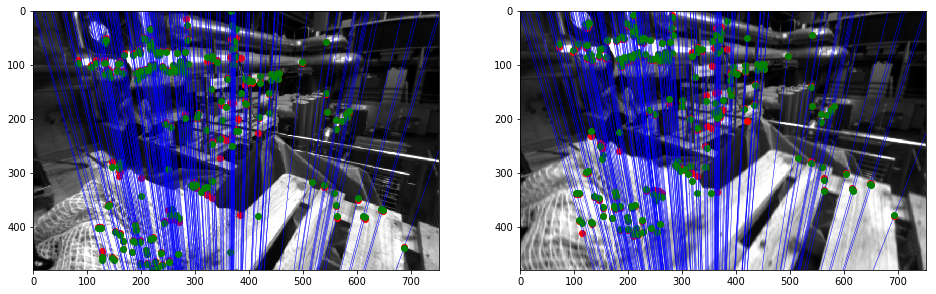

In [16]:
#--------------------------------
# Optical Flow related setting
#--------------------------------
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 200,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (20,20),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

START_FRAME = 0
STEP = 4

# No of frames to process - !!!process only two frames!!!, last digit is the gap
frame_range = range(START_FRAME, START_FRAME+STEP+1, STEP)

#-------------
# Processing cam
#-------------
dpi = 50

# Read 1st frame
cam0_ori = cv2.imread(cam0_img_list[frame_range[0]], cv2.IMREAD_GRAYSCALE)
# Image undistortion
cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)


# Create a figure of the right size with one axes that takes up the full figure
height, width = cam0.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)

# Show the gray img from camera 0
plt.subplot(121)
plt.imshow(cam0, cmap='gray', extent=[0,width,height,0])
plt.title("Continuous flow on 1st frame")

for fr in frame_range:
    print("OF: processing frame ", fr)
    
    cam0_ori = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    # Image undistortion
    cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)
    
    # Optical flow tracking
    # First frame, mark feature
    if fr==frame_range[0]:
        p0 = cv2.goodFeaturesToTrack(cam0, mask = None, **feature_params)
        # Save the very first set of features
        good_ori = p0.copy()
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='r')
        
    # Draw flow
    else:
        # OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
        plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
        cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color=cur_rand_color)

        p0 = p1.reshape(-1,1,2)
        print("num of total feature points:", p0.shape[0])
        print("num of active feature points:", good_new.shape[0])

    old_cam0 = cam0.copy()

    # Save pyplot image
    #plt.savefig(str(fr).zfill(3)+'.png')

# Draw last frame
plt.subplot(122)
plt.imshow(cam0, cmap='gray', extent=[0,width,height,0])
plt.title("Last frame")
plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

for idx in range(good_old.shape[0]):
    plt.plot([good_old[idx,0], good_new[idx,0]], 
                    [good_old[idx,1], good_new[idx,1]],
                    linestyle='-', color=cur_rand_color)
plt.show()

# Use opencv to show image
#cv2.imshow('cam0',cam0)
#k = cv2.waitKey(-1)
#cv2.destroyAllWindows()


#-------------------------------------------------------------------------------------
# Start pose estimation process
#-------------------------------------------------------------------------------------
    
# Read in current and previous frames
tmp_c = imread(cam0_img_list[fr])
frame_c = cv2.remap(tmp_c, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)
tmp_p = imread(cam0_img_list[fr-STEP]) 
frame_p = cv2.remap(tmp_p, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)

#-------------------
# Use all points
#-------------------
print("\nInitial pose estimation using all points:")
# Construct homogeneous coordinates points
one_col = np.ones_like(good_new[:,0]).reshape(-1,1)
pts_c = np.hstack((good_new[:,:2], one_col))
pts_p = np.hstack((good_old[:,:2], one_col))

# Calculate fundamental matrix F
F = normalized_eight_point_alg(pts_c, pts_p)

# Essential matrix
E = K.T.dot(F).dot(K)

# matched image points
img_pts_all = np.zeros([2*pts_c.shape[0], pts_c.shape[1]-1])
img_pts_all[::2,:] = pts_c[:,:-1]
img_pts_all[1::2,:]= pts_p[:,:-1]
img_pts_all = img_pts_all.reshape(-1,2,2)

# Estimate RT matrix from E
RT = estimate_RT_from_E(E, img_pts_all, K)

# Reproj erorr
init_err, inliers_cnt = eval_RT_thresh(RT, img_pts_all, K)
print("Mean reproj error: ", init_err, "inliers/total:", inliers_cnt, "/", img_pts_all.shape[0], "\n")

pFp = [pts_p[i].dot(F.dot(pts_c[i]))
    for i in range(pts_c.shape[0])]
print("p'^T F p =", np.abs(pFp).max())
#print("Fundamental Matrix from normalized 8-point algorithm:\n", F)
print("Estimated pose RT:\n", RT)

# Plotting the epipolar lines
plot_epipolar_lines_on_images(pts_c, pts_p, frame_c, frame_p, F)


#-------------------
# Ransac 8 pts
#-------------------
# Construct homogeneous coordinates points
one_col = np.ones_like(good_new[:,0]).reshape(-1,1)
pts_c = np.hstack((good_new[:,:2], one_col))
pts_p = np.hstack((good_old[:,:2], one_col))

RANSAC_TIMES = 500
INLIER_RATIO_THRESH = 0.8

min_err = init_err.copy()
min_RT = np.empty((3,4))

for i in range(RANSAC_TIMES):
    ransac_8 = np.random.randint(0, pts_c.shape[0], size=8)
    rand_pts_c = pts_c[ransac_8]
    rand_pts_p = pts_p[ransac_8]
 
    # Calculate fundamental matrix F
    F = normalized_eight_point_alg(rand_pts_c, rand_pts_p)
    
    # Essential matrix
    E = K.T.dot(F).dot(K)

    # matched image points
    img_pts = np.zeros([2*rand_pts_c.shape[0], rand_pts_c.shape[1]-1])
    img_pts[::2,:] = rand_pts_c[:,:-1]
    img_pts[1::2,:]= rand_pts_p[:,:-1]
    img_pts = img_pts.reshape(-1,2,2)

    # Estimate RT matrix from E
    RT = estimate_RT_from_E(E, img_pts, K)
    
    # Reproj erorr
    err, inliers_cnt = eval_RT_thresh(RT, img_pts_all, K)

    #print("Mean reproj error: ", err, "Inlier=", inliers_cnt)
    if err < min_err and (inliers_cnt/img_pts_all.shape[0])>INLIER_RATIO_THRESH:
        print("Mean reproj error: ", err, "Inlier/total=", inliers_cnt, "/", img_pts_all.shape[0])
        
        min_err = err.copy()
        min_F = F
        min_RT = RT


print("\nAfter 8pt algorithm RANSAC pose estimation:")

pFp = [pts_p[i].dot(min_F.dot(pts_c[i]))
            for i in range(pts_c.shape[0])]
print("p'^T F p =", np.abs(pFp).max())
print("Fundamental Matrix from normalized 8-point algorithm:\n", min_F)
print("Estimated pose RT:\n", min_RT)
#dist1 = compute_distance_to_epipolar_lines(pts_c, pts_p, min_F)
#dist2 = compute_distance_to_epipolar_lines(pts_p, pts_c, min_F.T)
#print("Distance to lines in image 1 for normalized:", dist1)
#print("Distance to lines in image 2 for normalized:", dist2)
# Plotting the epipolar lines
plot_epipolar_lines_on_images(pts_c, pts_p, frame_c, frame_p, min_F)



### Experiment with tile-based OF

image size (w, h):  752 480
Frame  3 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (599, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (583, 4)


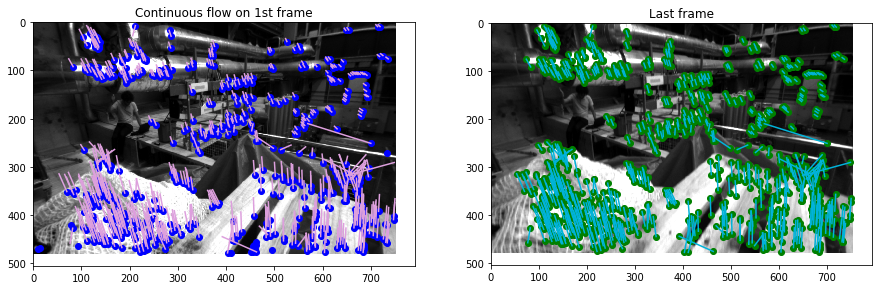


--------------------------------
Initial pose estimation using all points:
--------------------------------
Mean reproj error:  2.19735712433 inliers/total: 280 / 584 

p'^T F p = 6.44772227542
Estimated pose RT:
 [[ 0.99955899  0.00514792  0.02924607 -0.99618074]
 [-0.0062905   0.99921507  0.03911106 -0.07780087]
 [-0.02902177 -0.03927779  0.99880678  0.03963544]]

--------------------------------
Started RANSAC 8pt algorithm:
--------------------------------
Mean reproj error:  2.05297813549 Inlier/total= 517 / 584
Mean reproj error:  0.521294436299 Inlier/total= 556 / 584
Mean reproj error:  0.251054347586 Inlier/total= 557 / 584
Mean reproj error:  0.211642664038 Inlier/total= 557 / 584
Mean reproj error:  0.203030107326 Inlier/total= 557 / 584

After 8pt algorithm RANSAC pose estimation:
p'^T F p = 20.4377646773
Fundamental Matrix from normalized 8-point algorithm:
 [[  2.53392822e-06   1.79346904e-04  -1.93673472e-01]
 [ -1.72047280e-04  -3.06146565e-07   6.91312418e-02]
 [  1.9

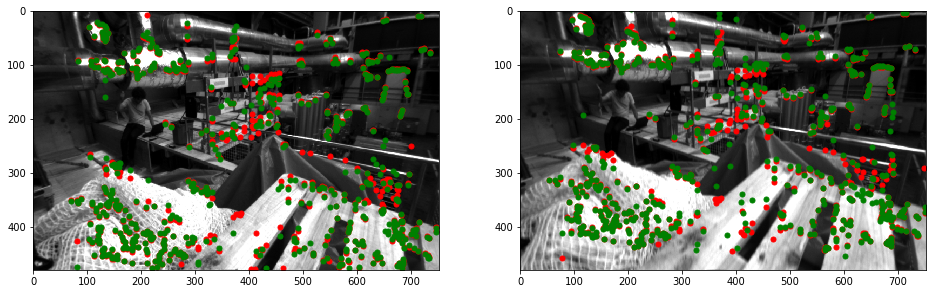

In [29]:
# Local scripts
import tile_of_func as of


#-------------
# Global Parameters
#-------------
# Tile size
tile_size = 200


# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'mav0/cam0/data/*.png'))

START_FRAME = 0
STEP = 3

# No of frames to process - !!!process only two frames!!!, last digit is the gap
frame_range = range(START_FRAME, START_FRAME+STEP+1, STEP)

#-------------
# Main(): Processing cam
#-------------

dpi = 50

# Read 1st frame
cam0_ori = cv2.imread(cam0_img_list[frame_range[0]], cv2.IMREAD_GRAYSCALE)
# Image undistortion
cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)


# Create a figure of the right size with one axes that takes up the full figure
height, width = cam0.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)

# Show the gray img from camera 0
plt.subplot(121)
plt.imshow(cam0, cmap='gray', extent=[0,width,height,0])
plt.title("Continuous flow on 1st frame")

for fr in frame_range:

    # Optical flow tracking
    # Feature list for consistency check
    feature_list = []
    
    cam0_ori = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    # Image undistortion
    cam0 = cv2.remap(cam0_ori, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)
    
    # First frame, mark feature
    if fr==0:

        (cam0_height, cam0_width) = cam0.shape
        print("image size (w, h): ", cam0_width, cam0_height)

        # Split image into tile_size to find features
        p0 = of.OF_TileFindFeature(cam0, tile_size, of.feature_params)
        #DEBUG print(p0.shape, p0)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='b')

    # Optical flow tracking
    else:


        print("Frame ", fr, ":")
        # Forward OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **of.lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        # Backward OF tracking
        p2, st2, err = cv2.calcOpticalFlowPyrLK(cam0, old_cam0, p1, None, **of.lk_params)

        # Clean-up feature_list
        feature_list = of.OF_FeatureListFilter(p0, p1, p2, cam0_width, cam0_height)

        # Draw filtered feature points and associated OF
        for idx in range(feature_list.shape[0]):
            plt.plot([feature_list[idx,0], feature_list[idx,2]], 
                            [feature_list[idx,1], feature_list[idx,3]],
                            linestyle='-', color='plum', markersize=3)

        # Save points for next round
        p0 = good_new.reshape(-1,1,2)

    old_cam0 = cam0.copy()

        
# Draw last frame
plt.subplot(122)
plt.imshow(cam0, cmap='gray', extent=[0,width,height,0])
plt.title("Last frame")
plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

for idx in range(good_old.shape[0]):
    plt.plot([good_old[idx,0], good_new[idx,0]], 
                    [good_old[idx,1], good_new[idx,1]],
                    linestyle='-', color=cur_rand_color, markersize=3)
plt.show()


#-------------------------------------------------------------------------------------
# Start pose estimation process
#-------------------------------------------------------------------------------------
    
# Read in current and previous frames
tmp_c = imread(cam0_img_list[fr])
frame_c = cv2.remap(tmp_c, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)
tmp_p = imread(cam0_img_list[fr-STEP]) 
frame_p = cv2.remap(tmp_p, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)

#-------------------
# Use all points
#-------------------
print("\n--------------------------------")
print("Initial pose estimation using all points:")
print("--------------------------------")
# Construct homogeneous coordinates points
one_col = np.ones_like(good_new[:,0]).reshape(-1,1)
pts_c = np.hstack((good_new[:,:2], one_col))
pts_p = np.hstack((good_old[:,:2], one_col))

# Calculate fundamental matrix F
F = normalized_eight_point_alg(pts_c, pts_p)

# Essential matrix
E = K.T.dot(F).dot(K)

# matched image points
img_pts_all = np.zeros([2*pts_c.shape[0], pts_c.shape[1]-1])
img_pts_all[::2,:] = pts_c[:,:-1]
img_pts_all[1::2,:]= pts_p[:,:-1]
img_pts_all = img_pts_all.reshape(-1,2,2)

# Estimate RT matrix from E
RT = estimate_RT_from_E(E, img_pts_all, K)

# Reproj erorr
init_err, inliers_cnt = eval_RT_thresh(RT, img_pts_all, K)
print("Mean reproj error: ", init_err, "inliers/total:", inliers_cnt, "/", img_pts_all.shape[0], "\n")

pFp = [pts_p[i].dot(F.dot(pts_c[i]))
    for i in range(pts_c.shape[0])]
print("p'^T F p =", np.abs(pFp).max())
#print("Fundamental Matrix from normalized 8-point algorithm:\n", F)
print("Estimated pose RT:\n", RT)



#-------------------
# Ransac 8 pts
#-------------------
print("\n--------------------------------")
print("Started RANSAC 8pt algorithm:")
print("--------------------------------")
# Construct homogeneous coordinates points
one_col = np.ones_like(good_new[:,0]).reshape(-1,1)
pts_c = np.hstack((good_new[:,:2], one_col))
pts_p = np.hstack((good_old[:,:2], one_col))

RANSAC_TIMES = 500
INLIER_RATIO_THRESH = 0.8

min_err = init_err.copy()
min_RT = np.empty((3,4))

for i in range(RANSAC_TIMES):
    ransac_8 = np.random.randint(0, pts_c.shape[0], size=8)
    rand_pts_c = pts_c[ransac_8]
    rand_pts_p = pts_p[ransac_8]
 
    # Calculate fundamental matrix F
    F = normalized_eight_point_alg(rand_pts_c, rand_pts_p)
    
    # Essential matrix
    E = K.T.dot(F).dot(K)

    # matched image points
    img_pts = np.zeros([2*rand_pts_c.shape[0], rand_pts_c.shape[1]-1])
    img_pts[::2,:] = rand_pts_c[:,:-1]
    img_pts[1::2,:]= rand_pts_p[:,:-1]
    img_pts = img_pts.reshape(-1,2,2)

    # Estimate RT matrix from E
    RT = estimate_RT_from_E(E, img_pts, K)
    
    # Reproj erorr
    err, inliers_cnt = eval_RT_thresh(RT, img_pts_all, K)

    #print("Mean reproj error: ", err, "Inlier=", inliers_cnt)
    if err < min_err and (inliers_cnt/img_pts_all.shape[0])>INLIER_RATIO_THRESH:
        print("Mean reproj error: ", err, "Inlier/total=", inliers_cnt, "/", img_pts_all.shape[0])
        
        min_err = err.copy()
        min_F = F
        min_RT = RT


print("\nAfter 8pt algorithm RANSAC pose estimation:")

pFp = [pts_p[i].dot(min_F.dot(pts_c[i]))
            for i in range(pts_c.shape[0])]
print("p'^T F p =", np.abs(pFp).max())
print("Fundamental Matrix from normalized 8-point algorithm:\n", min_F)
print("Estimated pose RT:\n", min_RT)
# Plotting the remapped points according to epipolar lines
plot_points_on_images(pts_c, pts_p, frame_c, frame_p, min_F)



## Trajectory drawing

Useful page: https://matplotlib.org/examples/mplot3d/lines3d_demo.html


### Load trajectory from dataset

In [10]:

def q2R(w, x, y, z):
    """
    Transform a unit quaternion into its corresponding rotation matrix (to
    be applied on the right side).
      
    :returns: transform matrix
    :rtype: numpy array
  
    """
    xx2 = 2 * x * x
    yy2 = 2 * y * y
    zz2 = 2 * z * z
    xy2 = 2 * x * y
    wz2 = 2 * w * z
    zx2 = 2 * z * x
    wy2 = 2 * w * y
    yz2 = 2 * y * z
    wx2 = 2 * w * x
      
    R = np.empty((3, 3), float)
    R[0,0] = 1. - yy2 - zz2
    R[0,1] = xy2 - wz2
    R[0,2] = zx2 + wy2
    R[1,0] = xy2 + wz2
    R[1,1] = 1. - xx2 - zz2
    R[1,2] = yz2 - wx2
    R[2,0] = zx2 - wy2
    R[2,1] = yz2 + wx2
    R[2,2] = 1. - xx2 - yy2
      
    return R
    
# Load leica0 sensor config - position measurement mounted on IMU (ADIS16448)
with open(basedir+'mav0/leica0/sensor.yaml') as fp:
    leica0_yaml = yaml.load(fp)
fp.close()
# T_BL - [R t] from MAV body coordinates to sensor (leica0) coordinates
#   As it is rigidly mounted on IMU, there's only translation from B.
T_BL = leica0_yaml['T_BS']['data']
T_BL_cols = leica0_yaml['T_BS']['cols']
T_BL_rows = leica0_yaml['T_BS']['rows']
T_BL = np.array(T_BL,dtype='float').reshape(T_BL_rows, T_BL_cols)
print("leica0 T_BL (MAV body to leica0 prism marker) = \n", T_BL)

# Trajectory points
T_WL_x = []
T_WL_y = []
T_WL_z = []

# Load ground truth data of leica0 prism marker
CSV_READ_N_LINES = 36000
with open(basedir+'mav0/state_groundtruth_estimate0/data.csv', newline='') as fp:
    reader = csv.reader(fp)
    # Skip first line, specifying column contents category
    next(reader)
    for i,row in enumerate(reader):
        tx, ty, tz, qw, qx, qy, qz = np.array(row[1:8]).astype('float')
        #print(tx, ty, tz, qw, qx, qy, qz)
        R = q2R(qw, qx, qy, qz)
        t = np.array([tx,ty,tz]).reshape(3,1)
        T_WL = np.hstack([R, t])
        #print("T_WL (world to leica0) = \n", T_WL)
        
        T_WL_x.append(tx)
        T_WL_y.append(ty)
        T_WL_z.append(tz)
        
        if i > CSV_READ_N_LINES:
            break
        
fp.close


leica0 T_BL (MAV body to leica0 prism marker) = 
 [[ 1.         0.         0.         0.0748903]
 [ 0.         1.         0.        -0.0184772]
 [ 0.         0.         1.        -0.120209 ]
 [ 0.         0.         0.         1.       ]]


<function TextIOWrapper.close>

### Draw the trajectory

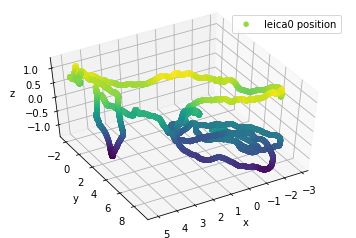

In [11]:

# Draw the trajectory 
matplotlib.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter3D(T_WL_x, T_WL_y, T_WL_z, c=T_WL_z, label='leica0 position')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Top-down view?
#ax.view_init(azim=270, elev=90)
#
ax.view_init(azim=60, elev=50)

plt.show()
